The following notebook was created on the Google Colab platform, it shows how to create regression models for sales prediction. It also shows the differences in prediction accuracy of machine learning models versus recurrent neural networks. It consists of 3 main parts, the first is data preparation, the second is model creation (the final, more comprehensive model is LSTM), the last part is sales prediction. 


# **Import of data and major libraries**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split,TimeSeriesSplit, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression,LogisticRegression ,SGDRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

Below is the connection to my private google drive where I keep my data, anyone can make their own connection, just provide the path to the folder with the data, no need to add data each time the environment disconnects 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Colab Notebooks/projects_recruitment
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/projects_recruitment
categories.csv	Empik.ipynb  model  pred.xlsx  sales.csv  traffic.csv


In [4]:
#import data
df1 = pd.read_csv("categories.csv", sep =';')
df2 = pd.read_csv("sales.csv", sep =';')
df3 = pd.read_csv("traffic.csv", sep =';')

In [5]:
#quick look at the data
print(df1.describe())
print(df1.info())
print(df1)

        product_id  category_id
count  3135.000000  3135.000000
mean   1568.000000    25.282616
std     905.140873    20.301615
min       1.000000     0.000000
25%     784.500000     8.000000
50%    1568.000000    20.000000
75%    2351.500000    38.500000
max    3135.000000    91.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3135 entries, 0 to 3134
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   product_id   3135 non-null   int64
 1   category_id  3135 non-null   int64
dtypes: int64(2)
memory usage: 49.1 KB
None
      product_id  category_id
0           1990            0
1           2361            1
2           1085            2
3           3091            3
4            955            4
...          ...          ...
3130        2474           18
3131        2638           13
3132        1233           35
3133         567           33
3134        2643           27

[3135 rows x 2 columns]


In [6]:
print(df2.describe())
print(df2.info())
print(df2)

       week_starting_date     product_id          sales
count        1.057810e+05  105781.000000  105781.000000
mean         2.019652e+07    1542.355007      29.750588
std          4.936736e+03     905.754736     104.557434
min          2.019011e+07       1.000000       1.000000
25%          2.019090e+07     737.000000       5.000000
50%          2.020030e+07    1532.000000       9.000000
75%          2.020082e+07    2310.000000      21.000000
max          2.020123e+07    3135.000000    5465.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105781 entries, 0 to 105780
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   week_starting_date  105781 non-null  int64
 1   product_id          105781 non-null  int64
 2   sales               105781 non-null  int64
dtypes: int64(3)
memory usage: 2.4 MB
None
        week_starting_date  product_id  sales
0                 20191209        1990      1
1          

In [7]:
print(df3.describe())
print(df3.info())
print(df3)

       week_starting_date     product_id        traffic
count        1.763240e+05  176324.000000  176324.000000
mean         2.019652e+07    1560.010923      17.805364
std          4.947337e+03     903.701849      70.371613
min          2.019011e+07       1.000000       1.000000
25%          2.019082e+07     770.000000       2.000000
50%          2.020030e+07    1553.000000       5.000000
75%          2.020082e+07    2331.000000      13.000000
max          2.020123e+07    3135.000000    9914.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176324 entries, 0 to 176323
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   week_starting_date  176324 non-null  int64
 1   product_id          176324 non-null  int64
 2   traffic             176324 non-null  int64
dtypes: int64(3)
memory usage: 4.0 MB
None
        week_starting_date  product_id  traffic
0                 20190107        1990        1
1      

# **Data preprocessing**

merging dataframes together with changing the date format, filling in empty values and dropping  products without categories 

In [8]:
df4=df2.merge(df1, how="inner", on='product_id')
df4.isna().sum()

week_starting_date    0
product_id            0
sales                 0
category_id           0
dtype: int64

In [9]:
data=pd.merge_ordered(df3,df4, on=("week_starting_date","product_id"), how= "outer")
data

week_starting_date  product_id  traffic  sales  category_id
0                 20190107           7      5.0    6.0         36.0
1                 20190107           8      1.0    NaN          NaN
2                 20190107           9      2.0    NaN          NaN
3                 20190107          10     20.0    NaN          NaN
4                 20190107          11      1.0    NaN          NaN
...                    ...         ...      ...    ...          ...
184153            20201228        3131      5.0    NaN          NaN
184154            20201228        3132      3.0   11.0         18.0
184155            20201228        3133      3.0    9.0          1.0
184156            20201228        3134      4.0    NaN          NaN
184157            20201228        3135     44.0    7.0         43.0

[184158 rows x 5 columns]

In [10]:
data.isna().sum()

week_starting_date        0
product_id                0
traffic                7834
sales                 78377
category_id           78377
dtype: int64

In [11]:
data=data.fillna(value={'sales':0,'traffic':0})
data['category_id'] = data['category_id'].fillna(data.groupby('product_id')['category_id'].transform("median"))
data=data.dropna()
data["week_starting_date"]= pd.to_datetime(data["week_starting_date"], format='%Y%m%d')
data

week_starting_date  product_id  traffic  sales  category_id
0              2019-01-07           7      5.0    6.0         36.0
1              2019-01-07           8      1.0    0.0          4.0
2              2019-01-07           9      2.0    0.0         30.0
3              2019-01-07          10     20.0    0.0         14.0
4              2019-01-07          11      1.0    0.0         55.0
...                   ...         ...      ...    ...          ...
184153         2020-12-28        3131      5.0    0.0         11.0
184154         2020-12-28        3132      3.0   11.0         18.0
184155         2020-12-28        3133      3.0    9.0          1.0
184156         2020-12-28        3134      4.0    0.0         17.0
184157         2020-12-28        3135     44.0    7.0         43.0

[184069 rows x 5 columns]

In [12]:
data.isna().sum()

week_starting_date    0
product_id            0
traffic               0
sales                 0
category_id           0
dtype: int64

In [13]:
print(data.info())
print(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184069 entries, 0 to 184157
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   week_starting_date  184069 non-null  datetime64[ns]
 1   product_id          184069 non-null  int64         
 2   traffic             184069 non-null  float64       
 3   sales               184069 non-null  float64       
 4   category_id         184069 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 8.4 MB
None
       week_starting_date  product_id  traffic  sales  category_id
0              2019-01-07           7      5.0    6.0         36.0
1              2019-01-07           8      1.0    0.0          4.0
2              2019-01-07           9      2.0    0.0         30.0
3              2019-01-07          10     20.0    0.0         14.0
4              2019-01-07          11      1.0    0.0         55.0
...            

### Pandas profiling - checking the most important statistics and correlations

In [34]:
!pip install pandas_profiling==2.7.1 #reboot the environment after installation in Colab

     |████████████████████████████████| 252 kB 5.0 MB/s 
     |████████████████████████████████| 58 kB 6.6 MB/s 
     |████████████████████████████████| 675 kB 58.9 MB/s 
     |████████████████████████████████| 4.7 MB 41.1 MB/s 
     |████████████████████████████████| 812 kB 77.1 MB/s 
     |████████████████████████████████| 28.5 MB 48 kB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=6ad588677bebb07bf3254783740d6bd3f49d332fe71f8c7f09cc3e1d972dd43b
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=b7c8bf02c46ff16bebadd26f760d807c8e907fe61c3c430f44b7ea46b9b28e56
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully built htmlmin imagehash
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling

In [35]:
from pandas_profiling import ProfileReport 
import pandas_profiling
pandas_profiling.ProfileReport(data) 

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
data=data[data["traffic"]<6000]

First of all, `Pandas profiling` showed us a correlation matrix from which it appears that only traffic and sales are correlated, so we will not take into consideration the product category column. Additionally, we can see that there is a value in traffic which is an extreme outlier, so we dropped it.

### Data visualisation

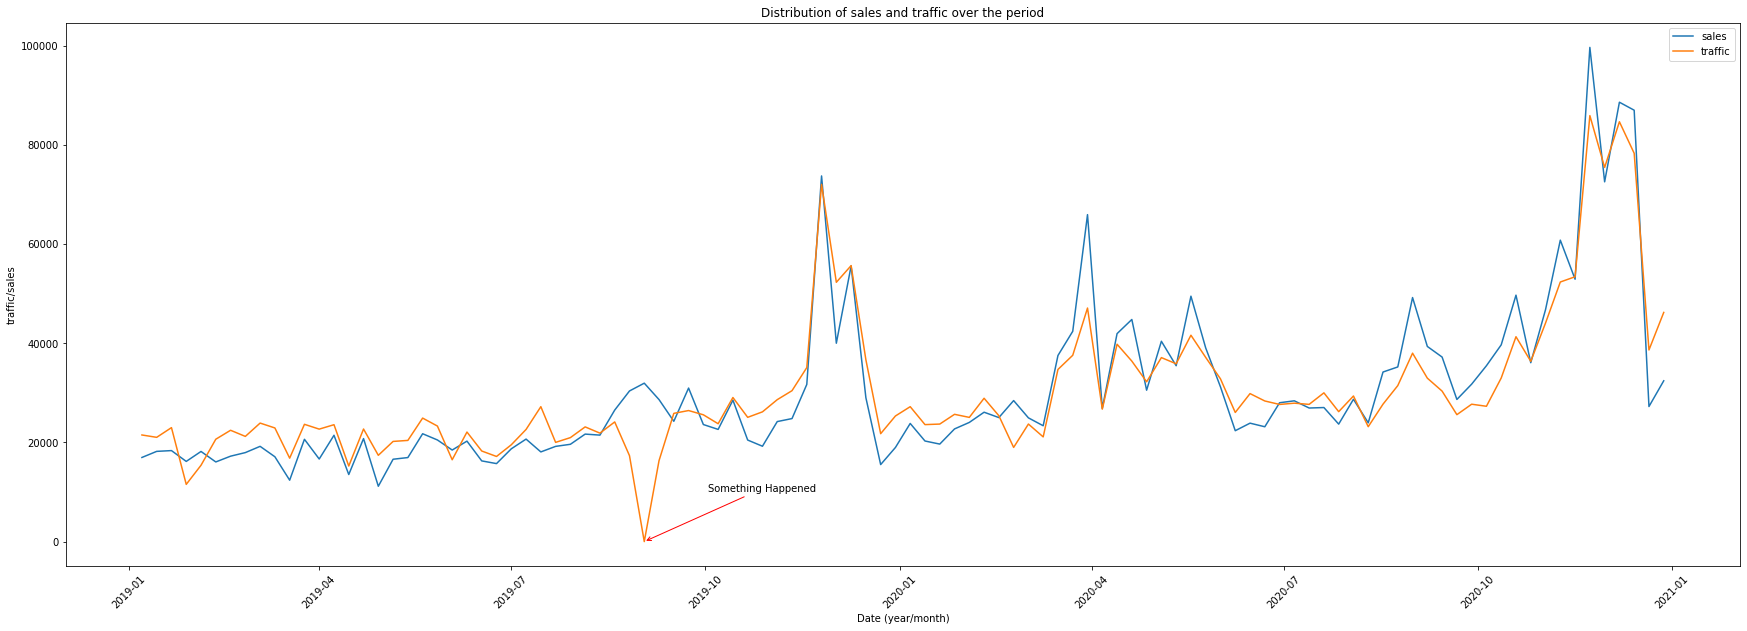

In [15]:
data_index=data.set_index("week_starting_date")

data_vizion=data_index.groupby("week_starting_date").sum()

fig,ax = plt.subplots(figsize=(30,10))
ax.plot(data_vizion.index, data_vizion['sales'],label='sales')
ax.plot(data_vizion.index, data_vizion['traffic'],label='traffic')
ax.set_xlabel('Date (year/month)')
ax.set_ylabel('traffic/sales')
ax.set_title('Distribution of sales and traffic over the period')
ax.annotate('Something Happened', xy=[pd.Timestamp("2019-09-02"),0],
              xytext=(pd.Timestamp("2019-10-02"),10000),
              arrowprops={"arrowstyle":"->","color":"red"})
ax.xaxis.set_tick_params(rotation=45)
ax.legend()
plt.show()


We can see how highly correlated sales are with traffic, additionally we can see that something happened on `2019-09-02` in traffic, maybe a site crash, either way we remove this data.

In [16]:
index_to_drop=data[data["week_starting_date"] == "2019-09-02" ].index
index_to_drop
data=data.drop(index_to_drop)

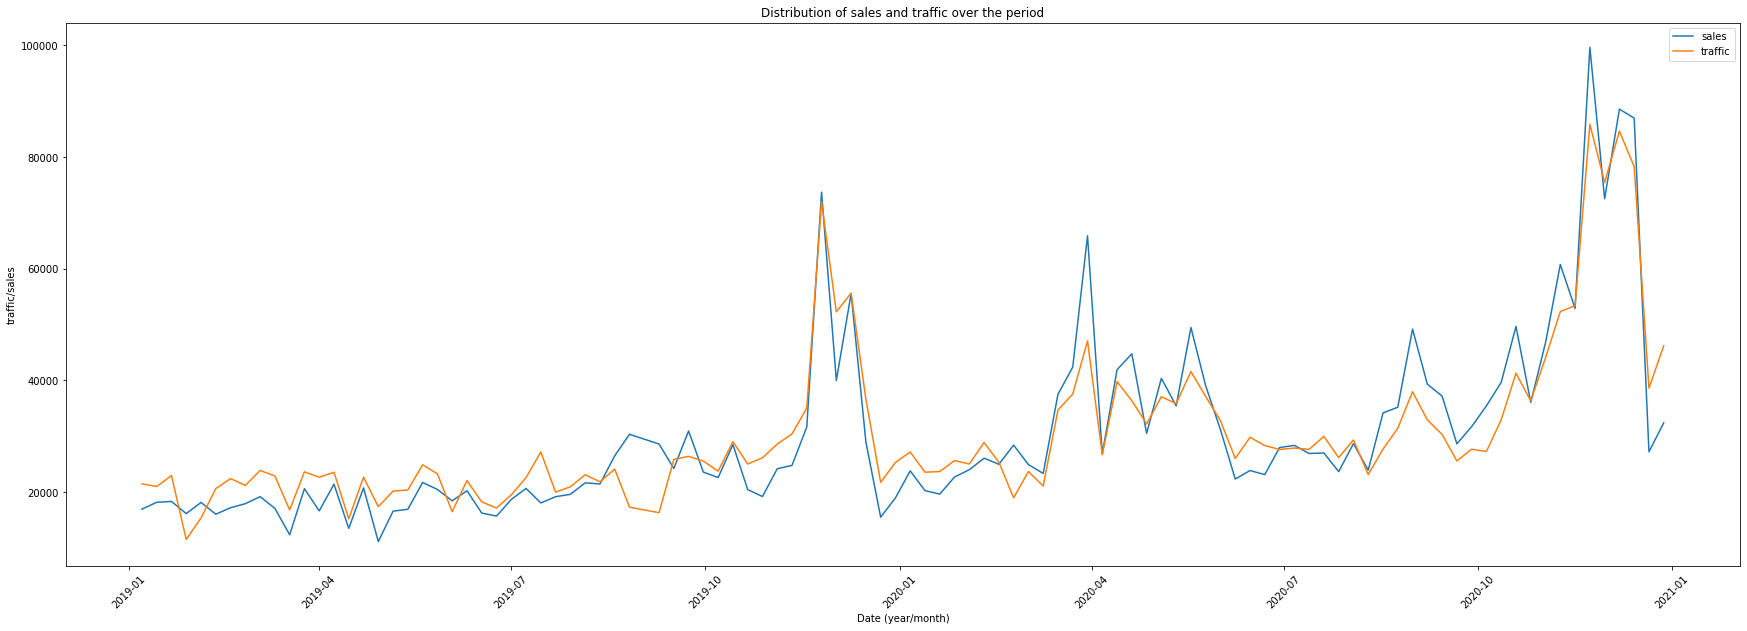

In [17]:
data_index=data.set_index("week_starting_date")
data_vizion=data_index.groupby("week_starting_date").sum()

fig,ax = plt.subplots(figsize=(30,10))
ax.plot(data_vizion.index, data_vizion['sales'],label='sales')
ax.plot(data_vizion.index, data_vizion['traffic'],label='traffic')
ax.set_xlabel('Date (year/month)')
ax.set_ylabel('traffic/sales')
ax.set_title('Distribution of sales and traffic over the period')
ax.xaxis.set_tick_params(rotation=45)
ax.legend()
plt.show()

Things are much better now. We are yet to see in more detail how the last year has been

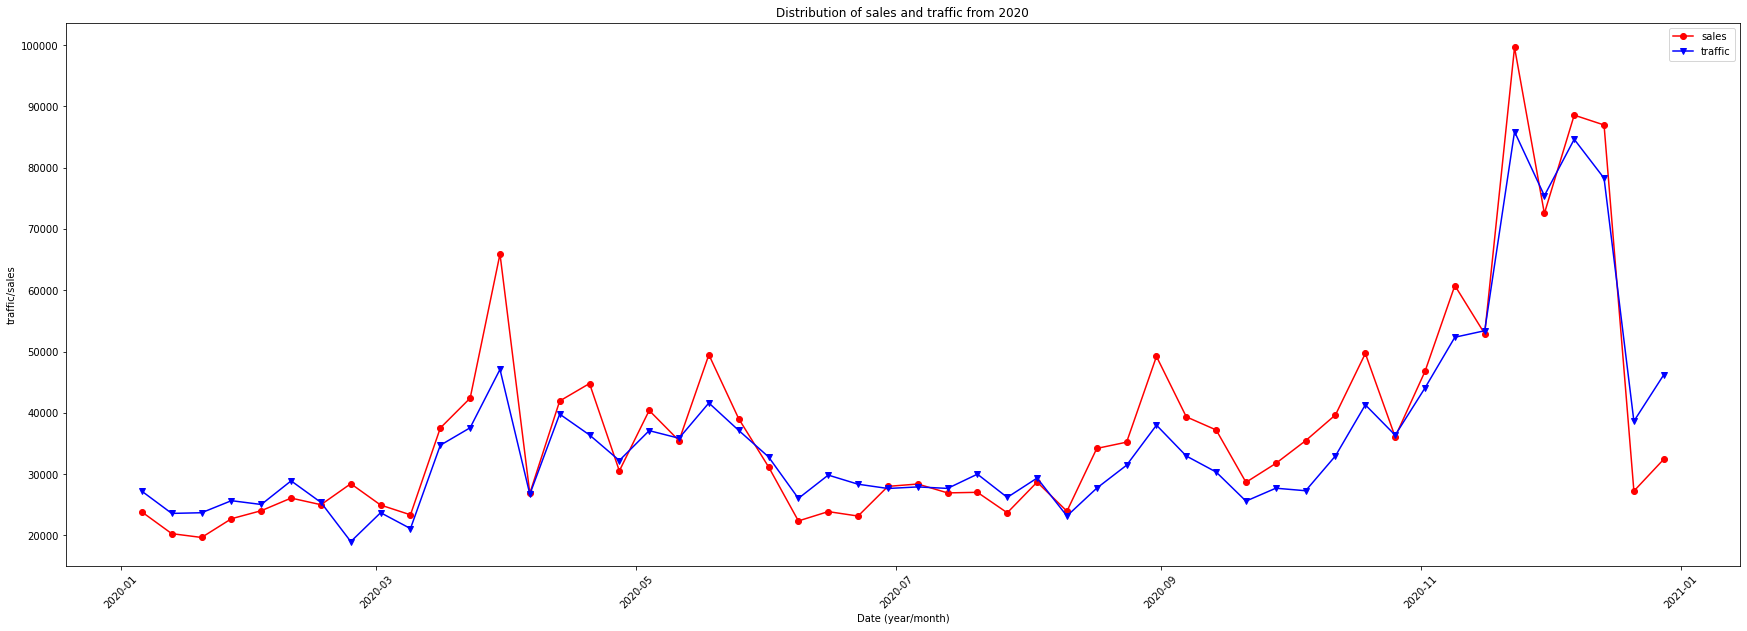

In [18]:
n="2020"
interesting_date=data_vizion[n:]

fig,ax = plt.subplots(figsize=(30,10))
ax.plot(interesting_date.index, interesting_date['sales'],marker='o',linestyle="-",color='r',label='sales')
ax.plot(interesting_date.index, interesting_date['traffic'],marker='v',linestyle="-",color='b',label='traffic')
ax.set_xlabel('Date (year/month)')
ax.set_ylabel('traffic/sales')
ax.set_title(f'Distribution of sales and traffic from {n}')
ax.xaxis.set_tick_params(rotation=45)
ax.legend()
plt.show()

In [ ]:
data=data.reset_index(drop=True)
data

# **Making models**

Before creating and training models, we need to change the date to int again, determine which variables will be dependent and independent, split the set into `train` and `test`, and create the WMAPE (Weighted Mean Absolute Percentage Error) metric, which is not implemented in the sklearn package. It places more emphasis on large values: it will it will treat differences between values 1 and 2 differently, and between 100 and 101 differently.

In [20]:
def wmape(y_true, y_pred): 
    return sum(np.abs(y_true - y_pred))*100 / sum(y_true)

In [21]:
data["week_starting_date"]=data["week_starting_date"].dt.strftime("%Y%m%d").astype(int)

In [22]:
X=data[["week_starting_date","traffic","product_id"]]
y=data["sales"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

### Decision Tree

Before we start training the model we will create validation data to see how effective the model really is. We will also use a training loop with different `min_samples_split` parameter to select the value needed for the highest model effectiveness. Our benchmark is `mean_squared_error`. The smaller the better.

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle = False)

In [61]:
min_samples_split_options = [2, 3, 5, 10, 50, 100, 1000, 2000]

In [65]:
def train_model(train_X, train_y, val_X, val_y, k):
    model = DecisionTreeRegressor(min_samples_split=k)
    model.fit(train_X, train_y)
    pred_train_y = model.predict(train_X)
    pred_val_y = model.predict(val_X)
    return mean_squared_error(train_y, pred_train_y, squared=False), \
            mean_squared_error(val_y, pred_val_y, squared=False)

In [66]:
train_metrics = []
val_metrics = []
for option in min_samples_split_options:
    train_score, val_score = train_model(X_train, y_train, X_val, y_val, option)
    train_metrics.append(train_score)
    val_metrics.append(val_score)

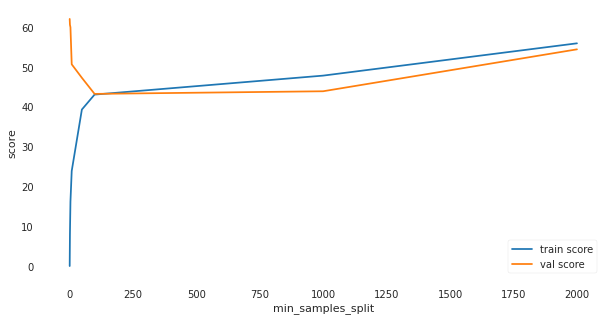

In [93]:
plt.figure(figsize=(10, 5))
plt.plot(min_samples_split_options, train_metrics, label="train score")
plt.plot(min_samples_split_options, val_metrics, label="val score")
plt.xlabel("min_samples_split")
plt.legend()
plt.ylabel("score")
plt.show()

As we can see, its smallest values are around 100.

And now we are going to do the same thing but using the `K-Fold` Cross Validator. It divides the dataset into k sequential folds. Each fold is then used once as validation, and the remaining folds are used as training set.


In [70]:
def train_model_cv(train_X, train_y, test_X, test_y, k):
    model = DecisionTreeRegressor(min_samples_split=k)
    model.fit(train_X, train_y)
    pred_y = model.predict(test_X)
    return r2_score(test_y, pred_y)

In [89]:
test_scores = []
for option in min_samples_split_options:
    cv = KFold(n_splits=5, shuffle=False)
    score = []
    for train, test in cv.split(X, y):
        X_train_cv, y_train_cv = X.iloc[train], y.iloc[train]
        X_test_cv, y_test_cv = X.iloc[test], y.iloc[test]
        score.append(train_model_cv(X_train_cv, y_train_cv, X_test_cv, y_test_cv, option))
    test_scores.append(sum(score) / len(score))

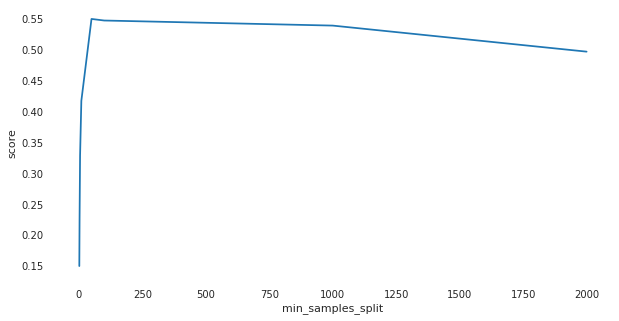

In [90]:
plt.figure(figsize=(10, 5))
plt.plot(min_samples_split_options, test_scores)
plt.xlabel("min_samples_split")
plt.ylabel("score")
plt.show()

And again we see that the best results will be for around 100 leaves, so we can train the model with this value




In [96]:
tree = DecisionTreeRegressor(min_samples_split=100)

tree.fit(X_train, y_train)

y_pred_test= tree.predict(X_test)

In [97]:
print(f"R2 score: {r2_score(y_test, y_pred_test)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test, squared=False)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred_test, squared=True)}")
print(f"WMAPE: {wmape(y_test,y_pred_test)}")

R2 score: 0.6080212968463301
MAE: 17.647537728496655
MSE: 61.58746632161079
RMSE: 3793.0160079155435
WMAPE: 79.00074184529318


R2 score is **60%** and the weighted average error is **79**

Below we will go through other machine learning models mainly on default settings

### Poly

In [101]:
poly = PolynomialFeatures(degree=3)

X_poly = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)

LRR = LinearRegression()
LRR.fit(X_poly, y_train)

y_pred_test = LRR.predict(X_poly_test) 

In [102]:
print(f"R2 score: {r2_score(y_test, y_pred_test)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test, squared=False)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred_test, squared=True)}")
print(f"WMAPE: {wmape(y_test,y_pred_test)}")

R2 score: 0.6892216629653001
MAE: 16.36731034084926
MSE: 54.83861416832632
RMSE: 3007.2736039025604
WMAPE: 73.26969228411502


The results for the polynomial regression are better than the decision tree and are R2 score: **69%**, WMAPE: **73** 

### SGD

In [103]:
scalerSGD = StandardScaler()

scalerSGD.fit(X_train)
scaled_X_train = scalerSGD.transform(X_train)
scalerSGD.fit(X_test)
scaled_X_test = scalerSGD.transform(X_test)

SGD= SGDRegressor()
SGD.fit(scaled_X_train, y_train)

y_pred_test= SGD.predict(scaled_X_test)

In [104]:
print(f"R2 score: {r2_score(y_test, y_pred_test)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test, squared=False)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred_test, squared=True)}")
print(f"WMAPE: {wmape(y_test,y_pred_test)}")

R2 score: 0.651701566798739
MAE: 16.456928720120388
MSE: 58.0546301102877
RMSE: 3370.340077242323
WMAPE: 73.67087677536358


### k-Nearest Neighbors

In [109]:
kNN = KNeighborsRegressor(leaf_size=100)

kNN.fit(X_train, y_train)
y_pred_train= kNN.predict(X_train)

y_pred_test= kNN.predict(X_test)

In [110]:
print(f"R2 score: {r2_score(y_test, y_pred_test)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test, squared=False)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred_test, squared=True)}")
print(f"WMAPE: {wmape(y_test,y_pred_test)}")

R2 score: 0.6445612653736299
MAE: 17.04184586835498
MSE: 58.646686393264744
RMSE: 3439.433824909944
WMAPE: 76.289309405426


### RandomForest

In [111]:
RF = RandomForestRegressor(min_samples_split=100)

RF.fit(X_train, y_train)

y_pred_test= RF.predict(X_test)

In [112]:
print(f"R2 score: {r2_score(y_test, y_pred_test)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test, squared=False)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred_test, squared=True)}")
print(f"WMAPE: {wmape(y_test,y_pred_test)}")

R2 score: 0.6648029011644393
MAE: 16.993709974936987
MSE: 56.95229473820921
RMSE: 3243.5638759478525
WMAPE: 76.07382488016785


### GradientBoosting

In [113]:
GR = GradientBoostingRegressor(min_samples_split=100)

GR.fit(X_train, y_train)

y_pred_test= GR.predict(X_test)

In [114]:
print(f"R2 score: {r2_score(y_test, y_pred_test)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test, squared=False)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred_test, squared=True)}")
print(f"WMAPE: {wmape(y_test,y_pred_test)}")

R2 score: 0.6907648097801664
MAE: 16.43673679778801
MSE: 54.70229620002216
RMSE: 2992.341209554959
WMAPE: 73.58048587391872


### AdaBoost

In [147]:
ADA = AdaBoostRegressor(n_estimators=1,learning_rate=10,loss="square")

ADA.fit(X_train, y_train)

y_pred_test= ADA.predict(X_test)

In [148]:
print(f"R2 score: {r2_score(y_test, y_pred_test)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test, squared=False)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred_test, squared=True)}")
print(f"WMAPE: {wmape(y_test,y_pred_test)}")

R2 score: 0.6115961928301707
MAE: 16.998070205466572
MSE: 61.30598026335994
RMSE: 3758.423216051479
WMAPE: 76.0933438324216


### XGBoost

In [161]:
XGB = xgb.XGBRegressor(n_estimators=1000  ,booster="gbtree",objective="reg:linear", subsample=0.8,colsample_bytree=0.85, eta=0.1,max_depth=10,seed=42)
XGB.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)])

[09:46:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:71.1462	validation_1-rmse:99.3723
[1]	validation_0-rmse:66.8827	validation_1-rmse:93.7566
[2]	validation_0-rmse:62.4782	validation_1-rmse:88.6181
[3]	validation_0-rmse:58.9245	validation_1-rmse:84.754
[4]	validation_0-rmse:55.3293	validation_1-rmse:81.0616
[5]	validation_0-rmse:52.0977	validation_1-rmse:77.5559
[6]	validation_0-rmse:50.814	validation_1-rmse:76.5553
[7]	validation_0-rmse:49.3366	validation_1-rmse:75.8056
[8]	validation_0-rmse:46.8618	validation_1-rmse:73.5947
[9]	validation_0-rmse:45.8219	validation_1-rmse:73.1211
[10]	validation_0-rmse:43.5988	validation_1-rmse:71.2656
[11]	validation_0-rmse:42.7173	validation_1-rmse:70.976
[12]	validation_0-rmse:40.7759	validation_1-rmse:69.4569
[13]	validation_0-rmse:38.9126	validation_1-rmse:67.3274
[14]	validation_0-rmse:37.4517	validation_1-rmse:65.5553
[15]	validation_0-rmse:36.1795	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [162]:
y_pred_test= XGB.predict(X_test) 

In [163]:
print(f"R2 score: {r2_score(y_test, y_pred_test)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_test, squared=False)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred_test, squared=True)}")
print(f"WMAPE: {wmape(y_test,y_pred_test)}")

R2 score: 0.6703289373640068
MAE: 16.605795290757445
MSE: 56.48088797206766
RMSE: 3190.090706113258
WMAPE: 74.33729096283956


In summary, all models oscillated between **65-70%** for the R2 score and between **73 and 79** errors for WMAPE. It would probably be possible to increase the effectiveness of the models by adjusting the hyperparameters accordingly.

### LSTM

Now we will use neural networks, specifically LSTM , to predict sales data but without correlation with `traffic`.

In [ ]:
# dropping the traffic column
data_LSTM=data[["week_starting_date","product_id","sales"]]
data_LSTM

In [ ]:
#Now we will transform the data on a scale from 0 to 1
#because this is the type of data that the LSTM network handles well

LSTM_scaler = MinMaxScaler(feature_range=(0, 1))
dataset = LSTM_scaler.fit_transform(data_LSTM)
dataset


In [26]:
#data split
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

146572 36644


In [27]:
#convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=2):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [28]:
#prepare the train and test datasets for modeling
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(146569, 2)
(36641, 2)
(146569,)
(36641,)


In [29]:
#changing the shape of the data for the model input
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
print(testX.shape)

(146569, 1, 2)
(36641, 1, 2)


In [30]:
model = Sequential()

model.add(LSTM(32, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4480      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


In [31]:
#model training with validation
history=model.fit(trainX, trainY, epochs=5, batch_size=200,validation_split=0.2, shuffle=False) 

Epoch 1/5
587/587 [==============================] - 5s 4ms/step - loss: 0.0062 - val_loss: 3.1871e-05
Epoch 2/5
587/587 [==============================] - 2s 3ms/step - loss: 0.0042 - val_loss: 2.2975e-06
Epoch 3/5
587/587 [==============================] - 2s 3ms/step - loss: 4.8227e-04 - val_loss: 7.8122e-09
Epoch 4/5
587/587 [==============================] - 2s 3ms/step - loss: 4.8188e-05 - val_loss: 1.8131e-07
Epoch 5/5
587/587 [==============================] - 2s 3ms/step - loss: 1.3532e-05 - val_loss: 2.1898e-07


In [32]:
y_pred_test= model.predict(testX)

In [ ]:
print(f"R2 score: {r2_score(testY, y_pred_test)}")
print(f"MAE: {mean_absolute_error(testY, y_pred_test)}")
print(f"MSE: {mean_squared_error(testY, y_pred_test, squared=False)}")
print(f"RMSE: {mean_squared_error(testY, y_pred_test, squared=True)}")
print(f"WMAPE: {np.average(wmape(testY,y_pred_test))}")

R2 score: 0.9689883947118432
MAE: 0.001582320265377382
MSE: 0.0016207704729292892
RMSE: 2.6268969259194314e-06


As you can see the results of the neural network are definitely better than the machine learning models, R2 score oscillates between **95-99%** and WMAPE around 1

Now let's see if the model is Overfitting or Underfitting

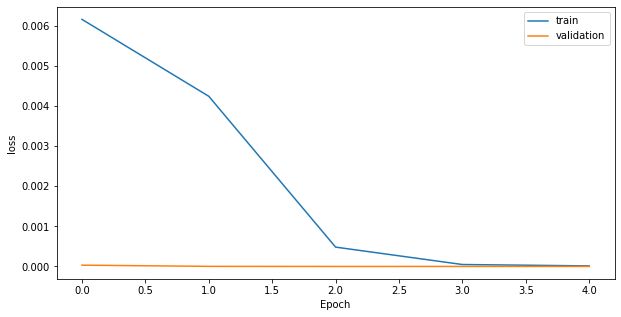

<Figure size 432x288 with 0 Axes>

In [33]:
check=pd.DataFrame({"loss":history.history['loss'],'val_loss':history.history['val_loss']})
check

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(check.index, check['loss'].astype(float))
ax.plot(check.index, check['val_loss'].astype(float))
ax.set_xlabel('Epoch')
ax.set_ylabel('loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
plt.savefig("model/plot.png")

As we can see both parameters oscillate down to 0.
Validation and training losses are decreasing and stabilising at the same point, which is a sign of correct model fitting to data

In [34]:
#save model
model.save('model/empik.h5')


# Sales prediction

### Preparing data for prediction

I will first check how many products there are and which date is the last to keep the time sequence

In [35]:
print(f'last date in sales.csv: {df2["week_starting_date"].max()}')
print(f'last date in traffic.csv: {df3["week_starting_date"].max()}')
print(f'number of products id in categories.csv: {df1.drop_duplicates()["product_id"].count()}')
print(f'number of products id in sales.csv: {df2.drop_duplicates(subset=["product_id"])["product_id"].count()}')
print(f'number of products id in traffic.csv: {df3.drop_duplicates(subset=["product_id"])["product_id"].count()}')

last date in sales.csv: 20201228
last date in traffic.csv: 20201228
number of products id in categories.csv: 3135
number of products id in sales.csv: 2926
number of products id in traffic.csv: 2912


In [36]:
# the next three weeks
pred_date=["20210104","20210111","20210118"]
pred_date

['20210104', '20210111', '20210118']

In [37]:
#all product numbers
pred_product_id=df1[["product_id"]]
pred_product_id

product_id
0           1990
1           2361
2           1085
3           3091
4            955
...          ...
3130        2474
3131        2638
3132        1233
3133         567
3134        2643

[3135 rows x 1 columns]


creation of data frame to predict, combined with trained data in order to keep proportions at the moment of scaling


In [38]:
pred_data_df= pd.MultiIndex.from_product([pred_date,
           pred_product_id["product_id"].values.tolist()],
           names=['week_starting_date', "product_id"]).to_frame().reset_index(drop=True)
pred_data_df=pd.DataFrame(pred_data_df)
data_LSTM_pred=data_LSTM[["week_starting_date","product_id"]]
data_full=pd.concat([data_LSTM_pred,pred_data_df],ignore_index=True)
data_full

week_starting_date  product_id
0                20190107           7
1                20190107           8
2                20190107           9
3                20190107          10
4                20190107          11
...                   ...         ...
192616           20210118        2474
192617           20210118        2638
192618           20210118        1233
192619           20210118         567
192620           20210118        2643

[192621 rows x 2 columns]

In [39]:
#scaling
pred_scaler = MinMaxScaler(feature_range=(0, 1))
pred_data_np = pred_scaler.fit_transform(data_full)
pred_data_np

array([[0.        , 0.00191449],
       [0.        , 0.00223357],
       [0.        , 0.00255265],
       ...,
       [1.        , 0.39310785],
       [1.        , 0.18059987],
       [1.        , 0.84301213]])

In [40]:
#delete training data
pred_data_np=np.delete(pred_data_np,np.s_[:len(data_LSTM_pred.index)],axis=0)
pred_data_np

array([[0.99930038, 0.6346522 ],
       [0.99930038, 0.75303127],
       [0.99930038, 0.34588385],
       ...,
       [1.        , 0.39310785],
       [1.        , 0.18059987],
       [1.        , 0.84301213]])

In [42]:
#changing the shape of the data for the model input
pred_data = np.reshape(pred_data_np, (pred_data_np.shape[0], 1, pred_data_np.shape[1]))
pred_data

array([[[0.99930038, 0.6346522 ]],

       [[0.99930038, 0.75303127]],

       [[0.99930038, 0.34588385]],

       ...,

       [[1.        , 0.39310785]],

       [[1.        , 0.18059987]],

       [[1.        , 0.84301213]]])

In [43]:
pred_data.shape

(9405, 1, 2)

### Using model to predict sales

In [44]:
#Sales prediction
pred_sales= model.predict(pred_data)
pred_sales

array([[0.78366005],
       [0.85476714],
       [0.6096504 ],
       ...,
       [0.63838285],
       [0.5108827 ],
       [0.90885985]], dtype=float32)

creation of a matrix of zeros to be merged with the prediction to keep the same shape during the rescaling, then the zeros will be removed

In [45]:
zeros=np.zeros((pred_sales.size,2), dtype=float)

In [46]:
pred_sales=np.hstack((zeros,pred_sales))
pred_sales

array([[0.        , 0.        , 0.78366005],
       [0.        , 0.        , 0.85476714],
       [0.        , 0.        , 0.60965037],
       ...,
       [0.        , 0.        , 0.63838285],
       [0.        , 0.        , 0.51088268],
       [0.        , 0.        , 0.90885985]])

In [47]:
pred_sales = LSTM_scaler.inverse_transform(pred_sales)
pred_sales = np.delete(pred_sales,(0,1),1)
pred_sales

array([[3760.78460014],
       [4102.02752274],
       [2925.71214223],
       ...,
       [3063.59930712],
       [2451.72596043],
       [4361.61841524]])

Finally, the prediction data is merged with the data used for the prediction and saved in an excel file

In [48]:
final_data=np.hstack((pred_data_df,pred_sales))
final_data=pd.DataFrame(final_data,columns=["week_starting_date","product_id","sales"])

In [ ]:
final_data.to_excel("pred.xlsx")

*As far as the future is concerned, it would be possible to classify products that do not sell and stop offering them, so that they do not generate storage and transport costs, in addition to which customer data could be added to make product recommendations.*